In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Create the AlexNet model
model = Sequential()

# Layer 1: Convolutional layer with 96 filters of size 11x11 and stride of 4
model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))

# Layer 2: Max pooling layer with size 3x3 and stride of 2
model.add(MaxPooling2D((3, 3), strides=(2, 2)))

# Layer 3: Convolutional layer with 256 filters of size 5x5 and padding
model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))

# Layer 4: Max pooling layer with size 3x3 and stride of 2
model.add(MaxPooling2D((3, 3), strides=(2, 2)))

# Layer 5: Convolutional layer with 384 filters of size 3x3 and padding
model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

# Layer 6: Convolutional layer with 384 filters of size 3x3 and padding
model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

# Layer 7: Max pooling layer with size 3x3 and stride of 2
model.add(MaxPooling2D((3, 3), strides=(2, 2)))

# Layer 8: Flatten layer to convert the output of the previous layer to a 1D array
model.add(Flatten())

# Layer 9: Fully connected layer with 512 neurons
model.add(Dense(512, activation='relu'))

# Layer 10: Dropout layer to reduce overfitting
model.add(Dropout(0.5))

# Layer 11: Fully connected layer with 512 neurons
model.add(Dense(512, activation='relu'))

# Layer 12: Dropout layer to reduce overfitting
model.add(Dropout(0.5))

# Layer 13: Output layer with 1 neuron for binary classification
model.add(Dense(1, activation='sigmoid'))




In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

In [3]:
model.load_weights('alexnet_model.hdf5')

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [6]:
def pred(img_array):
    p=model.predict(img_array)
    if p>0.5:
        print("Predicted: Cancer, p="+str(p) )
    else:
        print("Predicted:Not Cancer, p="+str(p) )

In [7]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


1/1 [==============================] - 0s 258ms/step
Predicted:Not Cancer, p=[[0.21492028]]


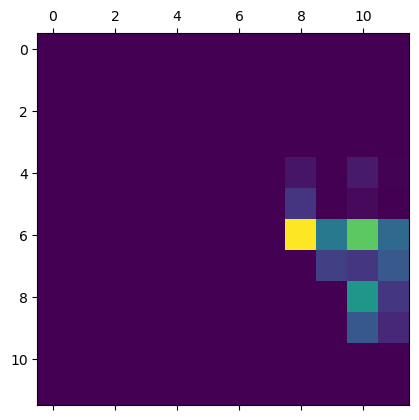

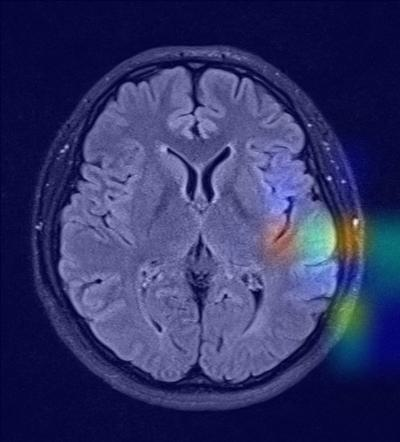

In [20]:
# Prepare image
img_path = r"archive\Brain Tumor Data Set\Brain Tumor Data Set\Brain Tumor\Cancer (54).tif"
#img_path = r"archive\Brain Tumor Data Set\Brain Tumor Data Set\Healthy\Not Cancer  (6).jpeg"
img_size=(224,224)
img_array = get_img_array(img_path, size=img_size)

pred(img_array)        
# Remove last layer's sigmoid
model.layers[-1].activation = None

# Generate class activation heatmap
last_conv_layer_name="conv2d_3"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)